In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import time

## Data Loading

In [4]:
sms_spam_df = pd.read_csv('archive/spam.csv', encoding='latin1')

In [5]:
sms_spam_df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
sms_spam_df.drop(['Unnamed: 2','Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace = True)

In [7]:
sms_spam_df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## EDA

### 1. Handling Null Values

In [8]:
# let's see how many null values we have
sms_spam_df.isnull().sum()

v1    0
v2    0
dtype: int64

In [16]:
''' No null values in either columms '''

' No null values in either columms '

### 2. Handling Duplicate Values

In [13]:
# check for duplicates
sms_spam_df['v2'].duplicated().sum()

403

In [18]:
# drop the irrelevant/ redundant rows of repeated messages to avoid 
# overfitting
sms_spam_df.drop_duplicates(subset=['v2'], inplace=True)

In [19]:
# confirm removal of duplicates
sms_spam_df['v2'].duplicated().sum()

0

In [21]:
display(sms_spam_df)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


### 3. Class Distributions

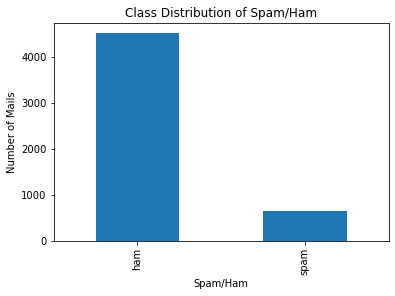

In [23]:
# Create a bar plot of the class distribution
class_counts = sms_spam_df['v1'].value_counts()
class_counts.plot(kind='bar')
plt.title('Class Distribution of Spam/Ham')
plt.xlabel('Spam/Ham')
plt.ylabel('Number of Mails')
plt.show()